In [2]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')
%matplotlib inline

# Bank Customer Segmentation Analysis - Student Exercise

In this lab, you will implement customer segmentation using K-means clustering. You'll learn how to:
1. Preprocess data for clustering
2. Perform and visualize dimensionality reduction
3. Implement K-means clustering from scratch
4. Evaluate clustering results

Follow the instructions in each section and fill in the code where indicated.

In [3]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')
%matplotlib inline

# --- Additional imports needed for the functions ---
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings

#=========================================================
# Load Data and Preprocess
#=========================================================
def load_data(filepath):
    """
    Loads, cleans, and preprocesses the bank marketing dataset.

    - Reads the CSV with semicolon delimiter.
    - Drops the target variable 'y'.
    - Maps 'month' to numerical values.
    - Scales numerical features.
    - One-hot encodes categorical features.
    """
    # Load the dataset
    df = pd.read_csv(filepath, delimiter=';')

    # Drop the target variable 'y' as this is an unsupervised task
    if 'y' in df.columns:
        df = df.drop('y', axis=1)

    # --- Data Preprocessing ---

    # 1. Map 'month' to numerical values
    month_map = {
        'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
        'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
    }
    df['month'] = df['month'].map(month_map)

    # 2. Identify numerical and categorical columns
    numerical_cols = [
        'age', 'balance', 'day', 'month', 'duration',
        'campaign', 'pdays', 'previous'
    ]
    categorical_cols = [
        'job', 'marital', 'education', 'default',
        'housing', 'loan', 'contact', 'poutcome'
    ]

    # 3. Scale Numerical Data
    scaler = StandardScaler()
    scaled_numerical_df = pd.DataFrame(
        scaler.fit_transform(df[numerical_cols]),
        columns=numerical_cols,
        index=df.index
    )

    # 4. One-Hot Encode Categorical Data
    categorical_df = pd.get_dummies(df[categorical_cols], drop_first=True)

    # 5. Combine processed data
    df_processed = pd.concat([scaled_numerical_df, categorical_df], axis=1)

    print(f"Data loaded and processed. Final shape: {df_processed.shape}")
    return df_processed

#=========================================================
# FOR PCA Dimensionality reduction
#=========================================================
def apply_pca(x, n_components):
    """
    Applies PCA to the data.

    Returns:
        pca (PCA object): The fitted PCA object.
        x_pca (np.array): The transformed data with reduced dimensions.
    """
    pca = PCA(n_components=n_components)
    x_pca = pca.fit_transform(x)

    # Print explained variance
    explained_variance = np.sum(pca.explained_variance_ratio_)
    print(f"PCA with {n_components} components applied.")
    print(f"Total Explained Variance: {explained_variance:.2%}")

    return pca, x_pca

#=========================================================
# FOR K-Means
#=========================================================
def find_optimal_clusters(x, max_clusters=10):
    """
    Calculates and plots the Elbow Curve to find the optimal
    number of clusters for K-Means.

    x: Input data
    max_clusters: The maximum number of clusters to test.
    """
    warnings.filterwarnings('ignore', category=FutureWarning) # Suppress n_init warning

    inertia_values = []
    cluster_range = range(1, max_clusters + 1)

    for k in cluster_range:
        kmeans = KMeans(
            n_clusters=k,
            init='k-means++',
            n_init=10,
            random_state=42
        )
        kmeans.fit(x)
        inertia_values.append(kmeans.inertia_)

    # Plot the Elbow Curve
    plt.figure(figsize=(10, 6))
    plt.plot(cluster_range, inertia_values, 'bo-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia (WCSS)')
    plt.title('Elbow Method For Optimal k')
    plt.xticks(cluster_range)
    plt.grid(True)
    plt.show()

def perform_kmeans_clustering(x, n_clusters=None):
    """
    Performs K-Means clustering on the data with a specified
    number of clusters.

    Returns:
        kmeans (KMeans object): The fitted KMeans model.
        labels (np.array): The cluster labels for each data point.
    """
    if n_clusters is None:
        print("Error: Please specify the 'n_clusters' parameter.")
        return None, None

    kmeans = KMeans(
        n_clusters=n_clusters,
        init='k-means++',
        n_init=10,
        random_state=42
    )
    labels = kmeans.fit_predict(x)

    print(f"K-Means clustering performed with {n_clusters} clusters.")
    return kmeans, labels

#=========================================================
# FOR Agglomerative
#=========================================================
def perform_agglomerative_clustering(x, n_clusters=None):
    """
    Performs Agglomerative Hierarchical Clustering on the data.

    Returns:
        agg_cluster (AgglomerativeClustering object): The fitted model.
        labels (np.array): The cluster labels for each data point.
    """
    if n_clusters is None:
        print("Error: Please specify the 'n_clusters' parameter.")
        return None, None

    agg_cluster = AgglomerativeClustering(
        n_clusters=n_clusters,
        linkage='ward'
    )
    labels = agg_cluster.fit_predict(x)

    print(f"Agglomerative clustering performed with {n_clusters} clusters.")
    return agg_cluster, labels

#=========================================================
# FOR Dendrogram
#=========================================================
def get_linkages(x):
    """
    Calculates the linkage matrix for hierarchical clustering.
    We use the 'ward' method, which minimizes variance.

    Returns:
        linked (np.array): The linkage matrix.
    """
    # Using 'ward' linkage as it's typically paired with
    # variance-minimization strategies like K-Means.
    linked = linkage(x, method='ward')
    return linked

def plot_dendrogram(linked):
    """
    Plots the dendrogram using the calculated linkage matrix.

    NOTE: This is computationally intensive. The plot is
    truncated to show the last 12 merged clusters for readability.
    """
    plt.figure(figsize=(14, 8))
    plt.title('Hierarchical Clustering Dendrogram (Truncated)')
    plt.xlabel('Data Points (or Cluster Index)')
    plt.ylabel('Distance (Ward)')

    dendrogram(
        linked,
        orientation='top',
        distance_sort='descending',
        show_leaf_counts=True,
        truncate_mode='lastp',  # Truncates to show only 'p' last merged clusters
        p=12,                   # Show the last 12 merges
        show_contracted=True,   # to represent the number of points in a cluster
    )
    plt.grid(axis='y')
    plt.show()

## 1. Data Loading and Preprocessing

First, complete the data preprocessing function below. You need to:
1. Load the data
2. Handle categorical variables
3. Scale numerical features

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')
%matplotlib inline

# Load Data and Preprocess
def load_data(filepath):
    """Load and preprocess the bank marketing dataset.

    TODO:
    1. Load the CSV file (hint: it uses semicolon separator)
    2. Convert categorical columns to numerical using LabelEncoder
    3. Scale the features using StandardScaler
    """
    # Your code here:
    # Load data
    df = pd.read_csv(filepath, delimiter=';') # TODO: Load CSV with correct separator

    # Create a copy to avoid SettingWithCopyWarning when encoding
    df_encoded = df.copy()

    # List of categorical columns to encode
    categorical_cols = ['job', 'marital', 'education', 'default', 'housing',
                        'loan', 'contact', 'month', 'poutcome', 'y']

    # TODO: Apply label encoding to categorical columns
    le = LabelEncoder()
    for col in categorical_cols:
        if col in df_encoded.columns:
            # Apply LabelEncoder to each specified column
            df_encoded[col] = le.fit_transform(df_encoded[col])

    # Select features for clustering
    features = ['age', 'balance', 'campaign', 'previous', 'job', 'education',
                'housing', 'loan', 'default']

    # TODO: Select features
    # Select the specified features from the encoded dataframe
    X = df_encoded[features]

    # TODO: Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X) # TODO: Apply StandardScaler

    return X_scaled, df

# Load and preprocess the data
X_scaled, data = load_data('bank-full.csv')
print("Data shape:", X_scaled.shape)
print("Scaled data (first 5 rows):")
print(X_scaled[:5])

Data shape: (45211, 9)
Scaled data (first 5 rows):
[[ 1.60696496  0.25641925 -0.56935064 -0.25194037 -0.10381968  1.03636182
   0.89391541 -0.43680347 -0.13548989]
 [ 0.28852927 -0.43789469 -0.56935064 -0.25194037  1.42400783 -0.30055587
   0.89391541 -0.43680347 -0.13548989]
 [-0.74738448 -0.44676247 -0.56935064 -0.25194037 -0.71495069 -0.30055587
   0.89391541  2.2893591  -0.13548989]
 [ 0.5710512   0.04720545 -0.56935064 -0.25194037 -1.02051619  2.37327951
   0.89391541 -0.43680347 -0.13548989]
 [-0.74738448 -0.44709091 -0.56935064 -0.25194037  2.03513884  2.37327951
  -1.11867408 -0.43680347 -0.13548989]]


Generating Feature Correlation Matrix...


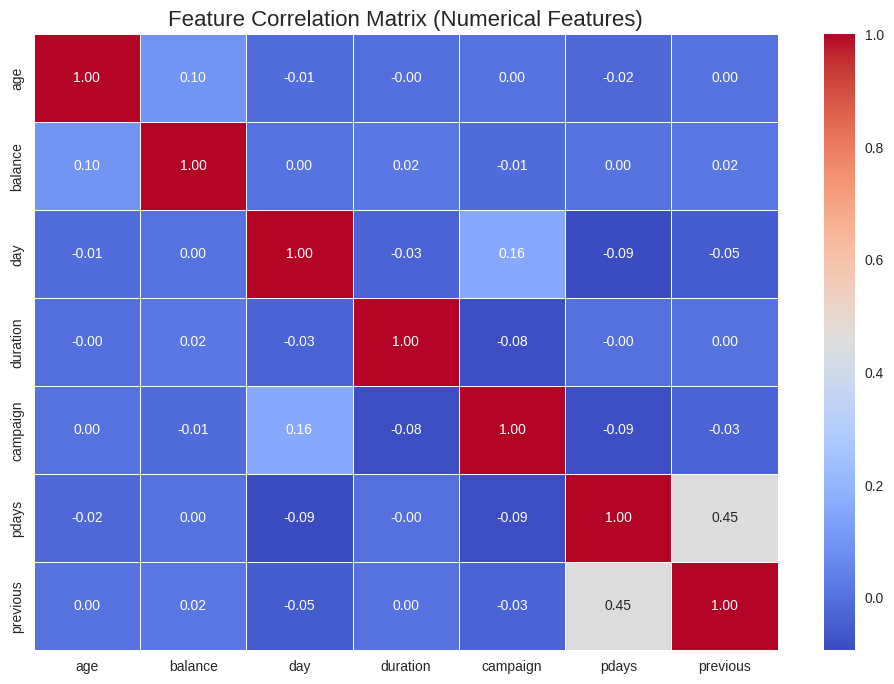

In [9]:
# --- CODE TO ADD FOR SCREENSHOT 1 ---
# This goes right after your cell where you run:
# X_scaled, data = load_data('bank-full.csv')

print("Generating Feature Correlation Matrix...")

# Select the original numerical features for a meaningful heatmap
# 'month' is excluded since it's cyclical, but we'll include the main ones.
numerical_features = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

plt.figure(figsize=(12, 8))
sns.heatmap(
    data[numerical_features].corr(),
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    linewidths=0.5
)
plt.title('Feature Correlation Matrix (Numerical Features)', fontsize=16)
plt.savefig('correlation_matrix.png')
plt.show()

In [5]:
import numpy as np

class KMeansClustering:
    """Minimal K-means skeleton for students to implement.

    Students should implement the core methods below:
    - _initialize_centroids
    - _assign_clusters
    - _update_centroids
    - fit

    Keep implementations simple and readable; tests and visualization code will
    use these methods once implemented.
    """
    def __init__(self, n_clusters=3, max_iters=100, random_state=42):
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.random_state = random_state
        self.centroids = None
        self.labels = None

    def _initialize_centroids(self, X):
        """Initialize centroids.

        - Randomly select `n_clusters` distinct points from X as initial centroids.
        - Return an array of shape (n_clusters, n_features).
        Hint: Use np.random.choice to pick indices.
        """
        # Set the random seed for reproducibility, as required by random_state
        np.random.seed(self.random_state)

        n_samples, n_features = X.shape

        # Randomly choose 'n_clusters' unique indices from the samples
        # replace=False ensures that we get distinct points
        indices = np.random.choice(n_samples, self.n_clusters, replace=False)

        # Select the data points at these indices as the initial centroids
        centroids = X[indices]

        return centroids

    def _assign_clusters(self, X):
        """Assign each sample in X to the nearest centroid.

        - Compute distance from each point to each centroid (Euclidean)
        - Return an integer array of shape (n_samples,) with cluster labels
        Hint: np.linalg.norm with axis manipulation or broadcasting helps here.
        """
        n_samples = X.shape[0]

        # Create an array to store the distances from each point to each centroid
        distances = np.zeros((n_samples, self.n_clusters))

        # Loop through each cluster and compute the distance from all points to its centroid
        for k in range(self.n_clusters):
            # Calculate the Euclidean distance (L2 norm) for all samples to centroid k
            # axis=1 calculates the norm for each sample (row)
            dist = np.linalg.norm(X - self.centroids[k], axis=1)
            distances[:, k] = dist

        # Find the index (cluster) of the minimum distance for each sample
        # axis=1 finds the minimum across the clusters (columns)
        labels = np.argmin(distances, axis=1)

        return labels

    def _update_centroids(self, X, labels):
        """Recompute centroids as the mean of points assigned to each cluster.

        - For each cluster id in 0..n_clusters-1 compute the mean of points
          assigned to that cluster. If a cluster has no points, consider reinitializing
          its centroid (or leave unchanged) — discuss in your report.
        - Return an array of shape (n_clusters, n_features).
        """
        n_features = X.shape[1]

        # Create an array to hold the new centroids
        new_centroids = np.zeros((self.n_clusters, n_features))

        # Loop through each cluster
        for k in range(self.n_clusters):
            # Get all the data points that are assigned to the current cluster k
            points_in_cluster = X[labels == k]

            # Check if the cluster has any points assigned to it
            if len(points_in_cluster) > 0:
                # If yes, compute the mean of these points as the new centroid
                new_centroids[k] = np.mean(points_in_cluster, axis=0)
            else:
                # If a cluster is empty (has no points), we keep its old centroid.
                # This is a simple strategy to prevent errors.
                # Your report should discuss this choice.
                new_centroids[k] = self.centroids[k]

        return new_centroids

    def fit(self, X):
        """Run K-means until convergence or max_iters.

        - Initialize centroids
        - Loop: assign clusters, update centroids
        - Stop early if centroids do not change (or change below a tiny threshold)
        - Store final labels in self.labels and centroids in self.centroids
        - Return self
        """
        # Step 1: Initialize centroids
        self.centroids = self._initialize_centroids(X)

        # Loop for a maximum of max_iters
        for i in range(self.max_iters):
            # Store the current centroids to check for convergence
            old_centroids = self.centroids

            # Step 2: Assign clusters (E-step)
            self.labels = self._assign_clusters(X)

            # Step 3: Update centroids (M-step)
            self.centroids = self._update_centroids(X, self.labels)

            # Step 4: Check for convergence
            # We use np.allclose to check if the new and old centroids are the same
            if np.allclose(old_centroids, self.centroids):
                print(f"Converged in {i+1} iterations.")
                break

        # If the loop completes without breaking (max_iters reached)
        else:
            print(f"Did not converge after {self.max_iters} iterations.")

        return self

    def predict(self, X):
        """Assign cluster labels to X using the learned centroids.

        Implementation may call _assign_clusters but should error if centroids
        are not yet initialized (i.e., if fit wasn't called).
        """
        if self.centroids is None:
            raise ValueError("Model has not been fitted yet. Call fit(X) first.")
        # Re-use the _assign_clusters method to find the closest centroid
        return self._assign_clusters(X)

## 2. Dimensionality Reduction

Before clustering, we often reduce the dimensionality of our data for better visualization and performance. Implement PCA below:

Explained variance captured by 2 components: 28.12%


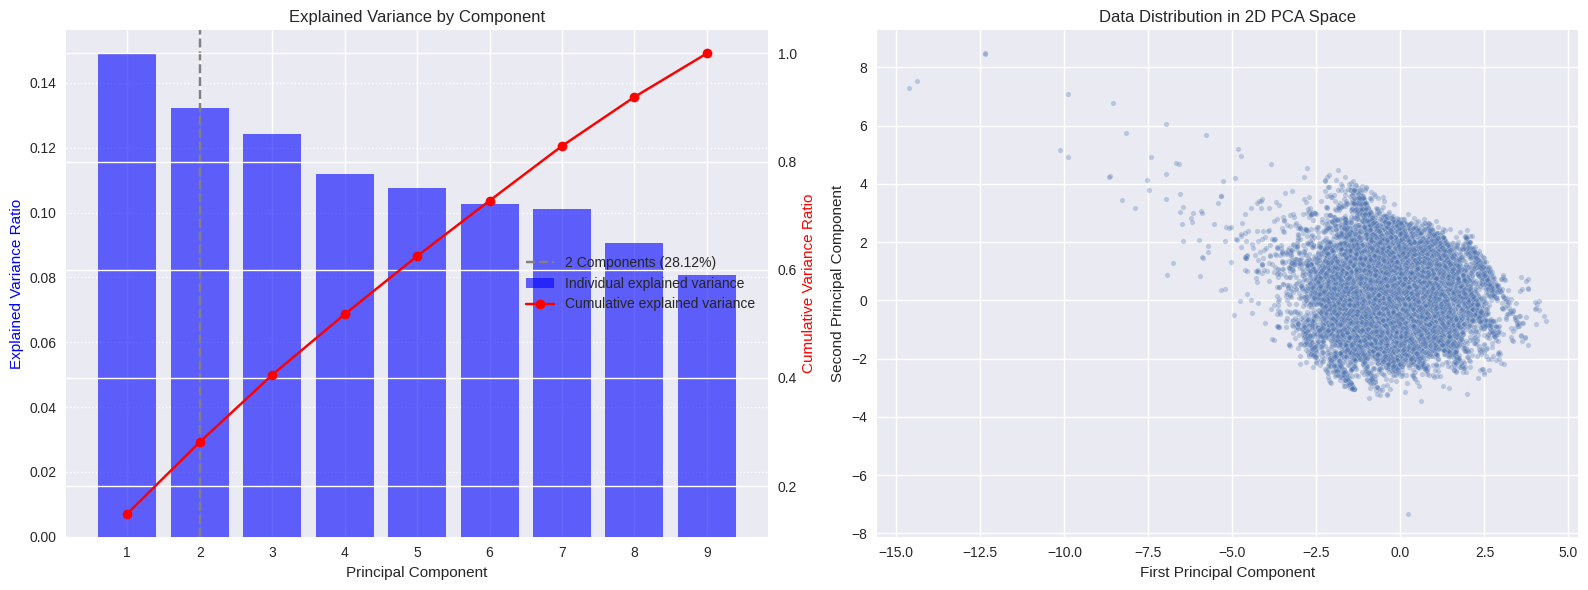

Shape after PCA: (45211, 2)


In [6]:
def apply_pca(X, n_components=2):
    """Apply PCA for dimensionality reduction.

    TODO:
    1. Initialize and fit PCA
    2. Transform the data
    3. Create visualizations to understand:
       - Explained variance ratio
       - Cumulative explained variance
       - Data distribution in 2D
    """
    # Your code here:

    # Fit PCA with all components (n_components=None) to get the full variance picture
    # We use the 9 features from X
    pca_full = PCA(n_components=None)
    pca_full.fit(X)

    # Initialize and fit PCA with n_components=2 for transformation
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    print(f"Explained variance captured by 2 components: {np.sum(pca.explained_variance_ratio_):.2%}")

    # TODO: Create visualization
    plt.figure(figsize=(16, 6)) # Use a wider figure to fit both plots

    # --- Plot 1: Explained Variance Ratio & Cumulative Variance ---
    ax1 = plt.subplot(1, 2, 1)

    # Get component numbers (1-indexed)
    n_components_full = pca_full.n_components_
    components = range(1, n_components_full + 1)

    # Get individual and cumulative variance ratios
    explained_variance_ratio = pca_full.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance_ratio)

    # Bar plot for individual variance
    ax1.bar(components, explained_variance_ratio, alpha=0.6, color='b',
            align='center', label='Individual explained variance')
    ax1.set_ylabel('Explained Variance Ratio', color='b')
    ax1.set_xlabel('Principal Component')
    ax1.set_title('Explained Variance by Component')
    ax1.set_xticks(components) # Show ticks for all 9 components
    ax1.grid(axis='y', linestyle=':')

    # Line plot for cumulative variance on a secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(components, cumulative_variance, 'r-o',
             label='Cumulative explained variance')
    ax2.set_ylabel('Cumulative Variance Ratio', color='r')

    # Add a vertical line at 2 components to show our cutoff
    ax1.axvline(x=2, color='grey', linestyle='--',
                label=f'2 Components ({cumulative_variance[1]:.2%})')

    # Combine legends from both axes
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='center right')

    # --- Plot 2: Data Distribution in 2D ---
    ax3 = plt.subplot(1, 2, 2)

    # Scatter plot of the 2D PCA-transformed data
    # Use alpha for transparency to see data density
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], alpha=0.3, s=15, ax=ax3)

    ax3.set_xlabel('First Principal Component')
    ax3.set_ylabel('Second Principal Component')
    ax3.set_title('Data Distribution in 2D PCA Space')
    ax3.grid(True)

    plt.tight_layout()
    plt.savefig('pca_plots.png') # Save the figure
    plt.show()

    return X_pca

# Apply PCA
X_pca = apply_pca(X_scaled)
print("Shape after PCA:", X_pca.shape)

## 3. Clustering Evaluation

Implement functions to evaluate the quality of your clustering results:

Calculating evaluation metrics for k=1 to 8
Converged in 2 iterations.
Converged in 32 iterations.
Converged in 27 iterations.
Converged in 25 iterations.
Converged in 34 iterations.
Converged in 24 iterations.
Converged in 99 iterations.
Converged in 35 iterations.


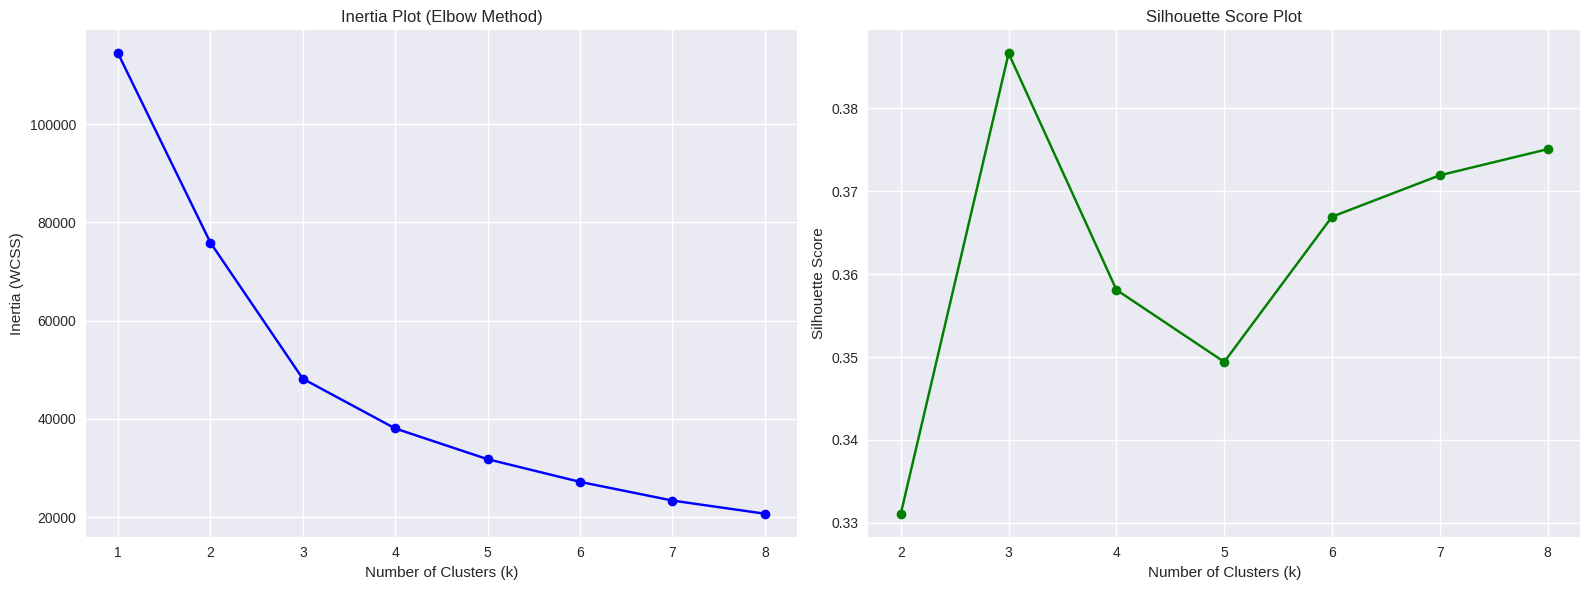

Converged in 27 iterations.

Fitting final model with k=3
Generating final visualization with all 3 plots...


/tmp/ipython-input-1351822415.py:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


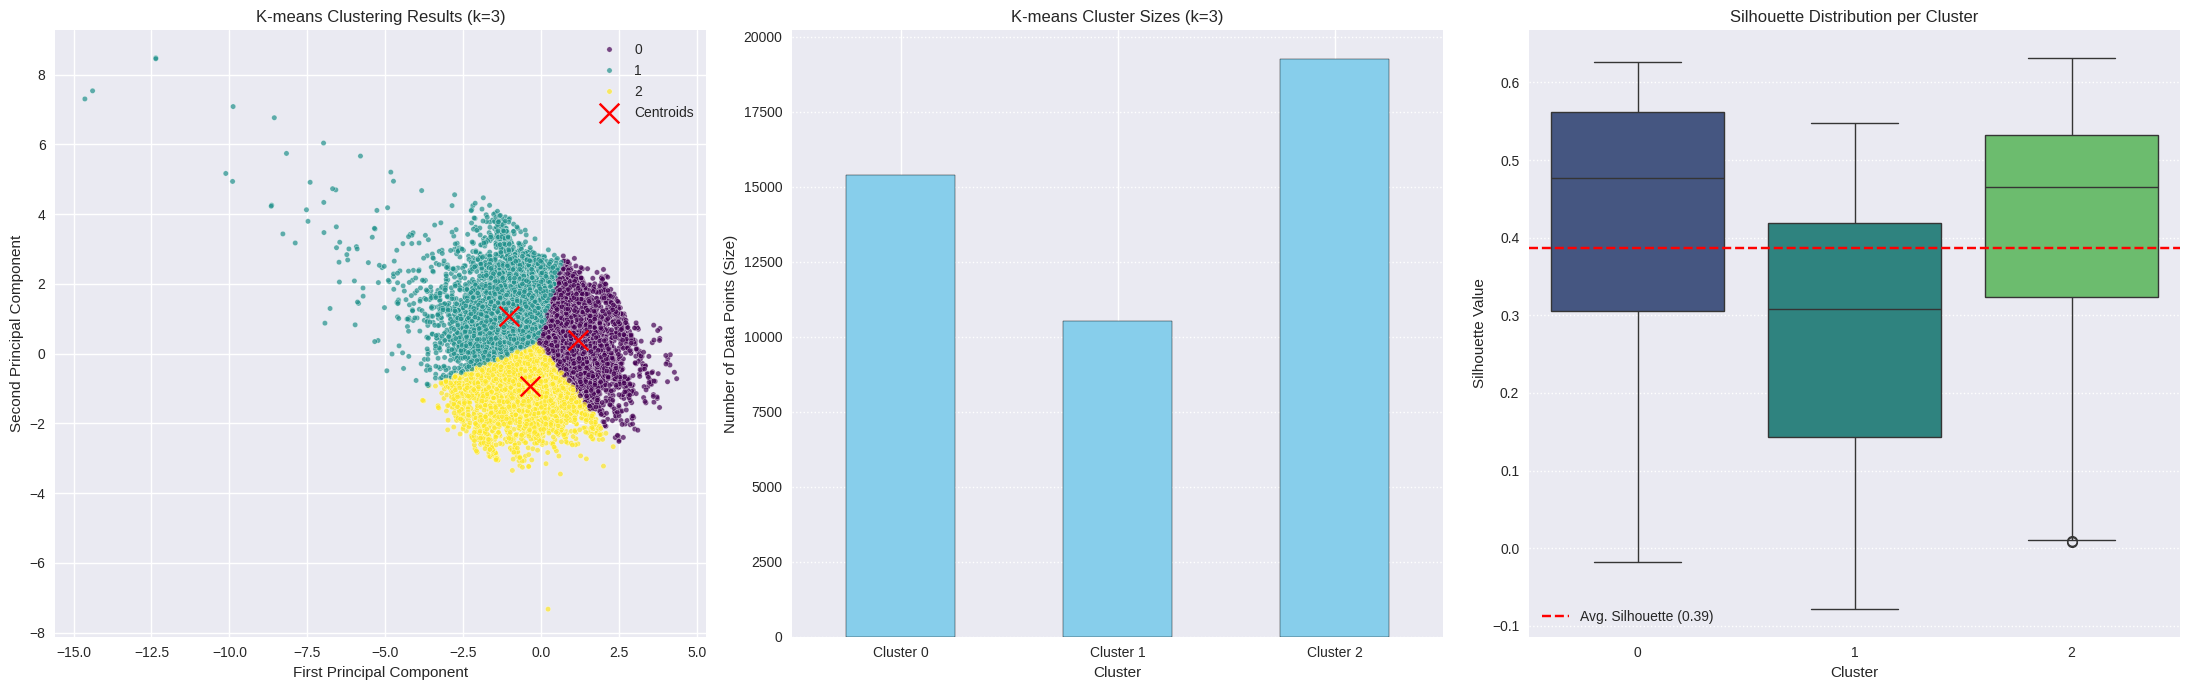


Clustering Evaluation (k=3):
Inertia: 48179.64
Silhouette Score: 0.39


In [11]:
from sklearn.metrics import silhouette_score, silhouette_samples
import pandas as pd

def calculate_inertia(X, labels, centroids):
    """Calculate the within-cluster sum of squares (inertia)."""
    inertia = 0
    n_clusters = len(centroids)

    for k in range(n_clusters):
        points_in_cluster = X[labels == k]
        if len(points_in_cluster) > 0:
            centroid = centroids[k]
            cluster_inertia = np.sum(np.linalg.norm(points_in_cluster - centroid, axis=1)**2)
            inertia += cluster_inertia

    return inertia

def plot_evaluation_curves(X, max_k=10):
    """
    Plot the elbow curve (Inertia) and Silhouette scores
    to find the optimal number of clusters.
    """
    inertias = []
    silhouette_scores = []

    K_range_inertia = range(1, max_k + 1)
    K_range_silhouette = range(2, max_k + 1)

    print("Calculating evaluation metrics for k=1 to", max_k)

    for k in K_range_inertia:
        kmeans_model = KMeansClustering(n_clusters=k, random_state=42)
        kmeans_model.fit(X)

        inertia = calculate_inertia(X, kmeans_model.labels, kmeans_model.centroids)
        inertias.append(inertia)

        if k >= 2:
            score = silhouette_score(X, kmeans_model.labels)
            silhouette_scores.append(score)

    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    plt.plot(K_range_inertia, inertias, 'bo-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia (WCSS)')
    plt.title('Inertia Plot (Elbow Method)')
    plt.xticks(K_range_inertia)
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(K_range_silhouette, silhouette_scores, 'go-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score Plot')
    plt.xticks(K_range_silhouette)
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('kmeans_evaluation_plots.png')
    plt.show()

    return inertias

inertias = plot_evaluation_curves(X_pca, max_k=8)

optimal_k = 3
kmeans = KMeansClustering(n_clusters=optimal_k, random_state=42)
kmeans.fit(X_pca)
print(f"\nFitting final model with k={optimal_k}")

print("Generating final visualization with all 3 plots...")

sample_silhouette_values = silhouette_samples(X_pca, kmeans.labels)
avg_silhouette = silhouette_score(X_pca, kmeans.labels)

plot_data = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'cluster': kmeans.labels,
    'silhouette': sample_silhouette_values
})

plt.figure(figsize=(22, 7))

plt.subplot(1, 3, 1)
sns.scatterplot(
    data=plot_data,
    x='PC1', y='PC2',
    hue='cluster',
    palette='viridis',
    alpha=0.7, s=15,
    legend='full'
)
plt.scatter(
    kmeans.centroids[:, 0], kmeans.centroids[:, 1],
    c='red', marker='x', s=200, label='Centroids'
)
plt.title(f'K-means Clustering Results (k={optimal_k})')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
cluster_counts = plot_data['cluster'].value_counts().sort_index()
cluster_counts.plot(
    kind='bar',
    color='skyblue',
    edgecolor='black'
)
plt.xlabel('Cluster')
plt.ylabel('Number of Data Points (Size)')
plt.title(f'K-means Cluster Sizes (k={optimal_k})')
plt.xticks(ticks=cluster_counts.index, labels=[f'Cluster {i}' for i in cluster_counts.index], rotation=0)
plt.grid(axis='y', linestyle=':')

plt.subplot(1, 3, 3)
sns.boxplot(
    data=plot_data,
    x='cluster',
    y='silhouette',
    palette='viridis'
)
plt.axhline(
    y=avg_silhouette,
    color="red",
    linestyle="--",
    label=f'Avg. Silhouette ({avg_silhouette:.2f})'
)
plt.title('Silhouette Distribution per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Silhouette Value')
plt.legend()
plt.grid(axis='y', linestyle=':')

plt.tight_layout()
plt.savefig('final_cluster_visualization_with_boxplot.png')
plt.show()

inertia = calculate_inertia(X_pca, kmeans.labels, kmeans.centroids)
print("\nClustering Evaluation (k=3):")
print(f"Inertia: {inertia:.2f}")
print(f"Silhouette Score: {avg_silhouette:.2f}")

## 4. Recursive Bisecting K-means (Student exercise)

This is an optional exercise for students who want to explore a hierarchical variant of K-means.

Task: implement a concise bisecting K-means procedure that recursively splits clusters into two until a target number of clusters is reached.

Learning goals:
- Understand how repeated binary splits can form a hierarchical clustering
- Practice applying K-means on subclusters and tracking labels/centroids

Hints:
- You can use sklearn's KMeans(k=2) for the binary split step, or reuse your `KMeansClustering` implementation.
- Keep label bookkeeping simple: use increasing integer labels for new clusters.
- Store split metadata (parent -> left/right) to enable a tree visualization later.

Running BisectingKMeans example...


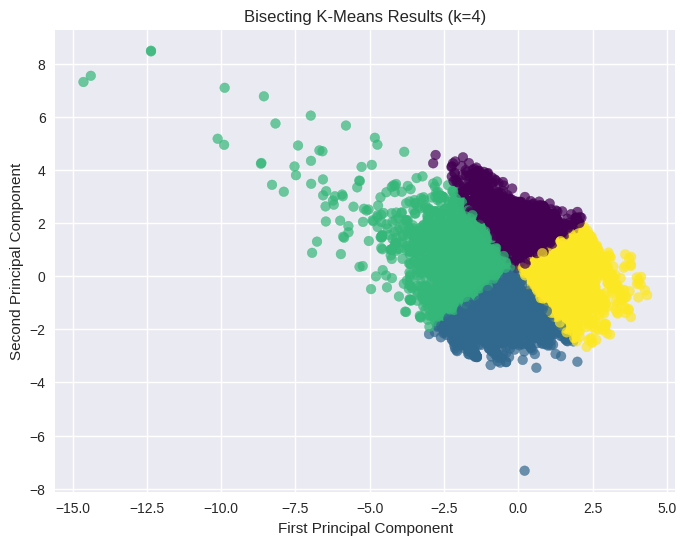


Final labels: [0 1 2 3]
Split tree (Parent -> (Child_0, Child_1)): {np.int64(0): (np.int64(0), 3), np.int64(1): (np.int64(1), 2)}


In [8]:
import numpy as np
from sklearn.cluster import KMeans
import pandas as pd # Using pandas for easy label counting

class BisectingKMeans:
    """Concise skeleton for students to implement a bisecting K-means algorithm.

    Students should implement `fit_predict` to recursively split clusters until
    `n_clusters` is reached.
    """
    def __init__(self, n_clusters, random_state=42):
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.labels_ = None
        # Optional: store mapping parent -> (left_label, right_label)
        self.split_tree = {}
        # Optional: store centroids per cluster id
        self.centers_ = {}

    def fit_predict(self, X):
        """Recursively bisect clusters until `n_clusters` is reached.

        TODO (student):
        - Start with all points assigned to label 0.
        - While number of unique labels < n_clusters:
            - Select a cluster to split (e.g., the largest cluster by size)
            - Run a binary KMeans (k=2) on the points in that cluster
            - Assign new labels (keep one child label as the original, give the other a new id)
            - Record parent -> (left, right) in `self.split_tree` and centroids in `self.centers_`
        - Set and return `self.labels_` (numpy array of length n_samples)
        """
        n_samples, n_features = X.shape

        # Start with all points in a single cluster (label 0)
        self.labels_ = np.zeros(n_samples, dtype=int)

        # Store the centroid for the initial cluster 0
        self.centers_[0] = np.mean(X, axis=0)

        # Counter for the next available cluster ID
        next_cluster_id = 1

        # Keep track of the current number of clusters
        current_num_clusters = 1

        # Handle the edge case of n_clusters=1
        if self.n_clusters == 1:
            return self.labels_

        # Loop until we reach the desired number of clusters
        while current_num_clusters < self.n_clusters:

            # 1. Select the cluster to split (the largest one)
            # Using pandas.Series.value_counts is a simple way to find the largest
            label_counts = pd.Series(self.labels_).value_counts()
            cluster_to_split = label_counts.idxmax() # Label of the largest cluster

            # Get the indices and data for the points in this cluster
            indices_to_split = np.where(self.labels_ == cluster_to_split)[0]
            data_to_split = X[indices_to_split]

            # If a cluster is too small (e.g., 1 point), it can't be split.
            # We skip it and the loop will pick the next largest.
            if len(data_to_split) < 2:
                # If all remaining clusters are < 2, we must stop.
                if label_counts.max() < 2:
                    print(f"Warning: Stopped splitting at {current_num_clusters} clusters. "
                          "Remaining clusters are too small to split further.")
                    break
                continue

            # 2. Run a binary KMeans (k=2) on the points in that cluster
            binary_kmeans = KMeans(
                n_clusters=2,
                random_state=self.random_state,
                n_init=10  # Use n_init=10 to suppress warnings
            )
            binary_labels = binary_kmeans.fit_predict(data_to_split)
            binary_centroids = binary_kmeans.cluster_centers_

            # 3. Assign new labels
            # The new cluster will get the next available ID
            new_cluster_label = next_cluster_id

            # Find the indices of the points that were assigned to binary_label '1'
            # These will form the new cluster
            new_cluster_mask = (binary_labels == 1)
            new_cluster_indices = indices_to_split[new_cluster_mask]

            # Update the main labels array.
            # Points with binary_label '0' keep the old `cluster_to_split` label.
            # Points with binary_label '1' get the `new_cluster_label`.
            self.labels_[new_cluster_indices] = new_cluster_label

            # 4. Record metadata
            # The parent `cluster_to_split` is now split into two children:
            # - Child 0 keeps the original label `cluster_to_split`
            # - Child 1 gets the new label `new_cluster_label`
            self.split_tree[cluster_to_split] = (cluster_to_split, new_cluster_label)

            # Update the centroid for the original label (now child 0)
            self.centers_[cluster_to_split] = binary_centroids[0]
            # Add the centroid for the new label (child 1)
            self.centers_[new_cluster_label] = binary_centroids[1]

            # Increment our counters
            current_num_clusters += 1
            next_cluster_id += 1

        return self.labels_

# --- Example Usage (as provided in your template) ---
# Make sure X_pca is defined from the previous step!

# Check if X_pca exists before running
if 'X_pca' in globals():
    print("Running BisectingKMeans example...")
    bisect = BisectingKMeans(n_clusters=4)
    labels = bisect.fit_predict(X_pca)

    plt.figure(figsize=(8, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.7)
    plt.title('Bisecting K-Means Results (k=4)')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.show()

    print("\nFinal labels:", np.unique(labels))
    print("Split tree (Parent -> (Child_0, Child_1)):", bisect.split_tree)
else:
    print("X_pca not defined. Please run the PCA step first to use this example.")

## Bonus Challenges

If you've completed the main tasks, try these extensions:

1. Implement k-means++ initialization
   - Instead of random initialization, use the k-means++ algorithm
   - This should give better and more consistent results

2. Add cluster interpretation
   - Analyze the characteristics of each cluster
   - What features distinguish one cluster from another?
   - Create visualizations to show cluster properties

3. Try different distance metrics
   - Implement Manhattan distance instead of Euclidean
   - Compare the clustering results

4. Add outlier detection
   - Identify points far from all centroids
   - How might you handle these outliers?

Remember to document your code and explain your findings!